In [249]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import wavfile
from matplotlib import pylab
import scipy
import stft
from scipy.signal import blackman
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import StandardScaler

In [250]:
%matplotlib inline

First, let's load some audio

In [284]:
rate, data = wavfile.read('2-05_Phantasy_for_Violin_and_Piano.wav')

/Users/georgeoblapenko/anaconda/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Next, we'll compute a spectrogram of a mono signal (obtained by summing the L & R channels) and using a Blackman window function

In [290]:
specgram = stft.spectrogram((data[:, 1] + data[:, 0]), framelength=2048, window=blackman, overlap=8)
audio_dat = stft.ispectrogram(np.log(1 + scipy.absolute(specgram)) , framelength=2048, overlap=8, window=blackman)
wavfile.write('schoenberg-new.wav', 44100, audio_dat * quietness)

We're interested in the absolute values of the spectrogram, and we'll log-scale it

In [287]:
log_spectrogram = np.log(1 + scipy.absolute(specgram))  # X axis - frequency bins, Y axis - time
print(log_spectrogram.shape)

(513, 31059)


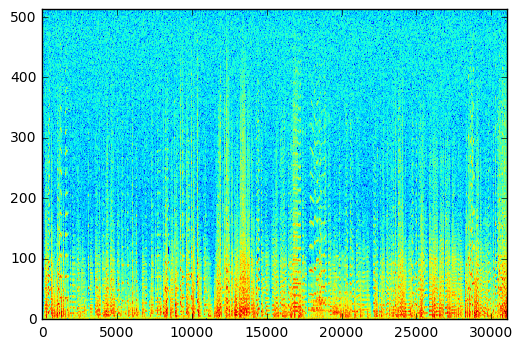

In [254]:
pylab.imshow(log_spectrogram, origin='lower', aspect='auto',
             interpolation='nearest')

Now we'll specify for each moment of time `t` which preceding intervals of the form `[t-a,t-b]` we want to use for feature extraction. So if for each interval we have `N` different features, the total amount of different features we'll have is equal to `N * n_intervals`.

We want to have varied information from the audio, so we sample features not for every frame, but each `step_size` frames

In [259]:
steps = [(-1000, -1), (-500, -1), (-100, -5), (-10, -1), (-2, -1)]
min_offset = max([-(i[0]) for i in steps])
step_size = 25

In [260]:
min_offset

1000

We want to have the frequency content of an interval as a (vector) feature; but we have too many frequency bins, so we just reduce their number by summation of their content.

In [261]:
freq_avg_step = 19
num_freq_bins_reduced = log_spectrogram.shape[0]//freq_avg_step
print(num_freq_bins_reduced)

27


Some feature extraction functions

In [262]:
def get_avg_amplitude(spgram_slice):
    return np.sum(spgram_slice / spgram_slice.shape[1])  # gets the average amplitude of the slice

In [263]:
def get_loudest_bin(spgram_slice):
    tmp = np.sum(spgram_slice, axis=1) / spgram_slice.shape[1]
    return np.argmax(tmp)  # returns the index of the loudest frequency bin, the slice is averaged

Now we let's extract the features and the spectral content for each frame

In [264]:
def get_features_for_frame(log_spgram_slice, scalar_functions, n_features):
    res = np.zeros(n_features)
    counter = 0
    for s_f in scalar_functions:
        for slicing in steps:
            a = min_offset + slicing[0]
            b = min_offset + slicing[1]
            res[counter] = s_f(log_spgram_slice[:, a:b])
            counter += 1
    for j in range(num_freq_bins_reduced):
        res[counter + j] = np.sum(log_spgram_slice[j * freq_avg_step:(j+1) * freq_avg_step, -1])
    return res

In [265]:
def process_spectrogram(log_spgram, scalar_functions, n_slices, n_features):
    # features, frequency content - X, Y
    # n_slices - the number of data points
    loc_Y = np.zeros([n_slices, log_spgram.shape[0]])
    loc_X = np.zeros([n_slices, n_features])
    for i in range(n_slices):
        loc_Y[i] = log_spgram[:, min_offset + step_size * i]
        loc_X[i, :] = get_features_for_frame(log_spgram[:,min_offset + step_size * i:2 * min_offset + step_size * i],
                                             scalar_functions, n_features)
#         counter = 0
#         for s_f in scalar_functions:
#             for slicing in steps:
#                 a = min_offset + step_size * i + slicing[0]
#                 b = min_offset + step_size * i + slicing[1]
#                 loc_X[i, counter] = s_f(log_spgram[:, a:b])
#                 counter += 1
#         for j in range(num_freq_bins_reduced):
#             loc_X[i, counter + j] = np.sum(log_spgram[j * freq_avg_step:(j+1) * freq_avg_step,
#                                                       min_offset + step_size * i - 1])
    return [loc_X, loc_Y]

In [266]:
n_samples = 1000
X, Y = process_spectrogram(log_spectrogram, [get_avg_amplitude, get_loudest_bin],
                           n_samples, 2 * len(steps) + num_freq_bins_reduced)

Next, we scale the features.

In [267]:
feature_scaler = StandardScaler()
X = feature_scaler.fit_transform(X)

Then, we train a regressor for each frequency band

In [268]:
predictors = []
for i in range(Y.shape[1]):
    if i%50 == 0:
        print(i)
    predictor = XGBRegressor()
    predictor.fit(X, Y[:, i])
    predictors.append(predictor)

0
50
100
150
200
250
300
350
400
450
500


Let's then try and generate some new audio. First, we'll take a chunk of the audio that hasn't been fed to our model before, to use a starting point. At some point, the model will only generate audio based on only newly generated audio

In [269]:
min_offset

1000

In [270]:
gen_start = min_offset + n_samples * step_size
print(gen_start)  # the starting point of the seed audio
generate_size = 2000  # how many samples we want to generate
keep_starting_audio = True  # if False, we cut off the starting point of the seed audio
result = np.zeros([log_spectrogram.shape[0], generate_size + min_offset])
feat_arr = np.zeros([1, 2 * len(steps) + num_freq_bins_reduced])

for i in range(min_offset):
    result[:, i] = log_spectrogram[:, gen_start + i]

    
for i in range(generate_size):
    if i%100 == 0:
        print(i)
    feat_arr[0,:] = get_features_for_frame(result[:, i:i+min_offset], [get_avg_amplitude, get_loudest_bin],
                                           2 * len(steps) + num_freq_bins_reduced)
    for k in range(log_spectrogram.shape[0]):
        result[k, min_offset+i] = predictors[k].predict(feature_scaler.transform(feat_arr))
        
if not keep_starting_audio:
    result = result[:, min_offset:]

26000
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [271]:
result[result<0] = 0.

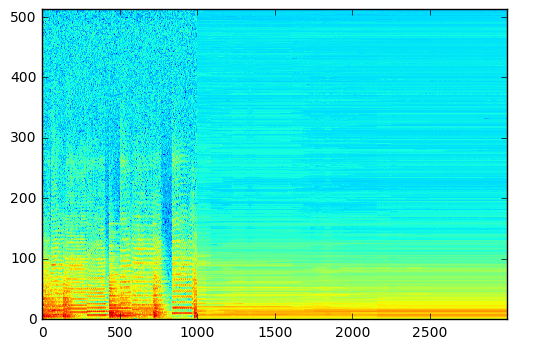

In [272]:
pylab.imshow(result, origin='lower', aspect='auto',
             interpolation='nearest')

In [273]:
newmusic_to_write = np.exp(result) - 1

In [274]:
audio_dat = stft.ispectrogram(result, framelength=1024, overlap=2, window=blackman)

In [275]:
audio_dat.shape

(1535488,)

In [276]:
quietness = 0.9

In [277]:
wavfile.write('schoenberg-new.wav', 44100, audio_dat * quietness)